In [17]:
import torch
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error


#### unsqueez() 함수 이해하기

In [12]:
# 지정한 위치에 차원하나를 추가
# 예를 들어 2,2 텐서에 unsqueeze(0)를 수행하면 텐서의 맨 앞에 차원을 추가 => (1,2,2)
tensor1 = torch.Tensor(np.ones((2,2)))
print("Original:")
print(tensor1)
print(tensor1.size())
print("unsqueeze(0): ")
usqz0 = tensor1.unsqueeze(0) 
print(usqz0)
print(usqz0.size())
print("unsqueeze(1): ")
usqz1 = tensor1.unsqueeze(1)
print(usqz1)
print(usqz1.size())
print("unsqueeze(2): ")
usqz2 = tensor1.unsqueeze(2)
print(usqz2)
print(usqz2.size())

Original:
tensor([[1., 1.],
        [1., 1.]])
torch.Size([2, 2])
unsqueeze(0): 
tensor([[[1., 1.],
         [1., 1.]]])
torch.Size([1, 2, 2])
unsqueeze(1): 
tensor([[[1., 1.]],

        [[1., 1.]]])
torch.Size([2, 1, 2])
unsqueeze(2): 
tensor([[[1.],
         [1.]],

        [[1.],
         [1.]]])
torch.Size([2, 2, 1])


#### 5.1 다층 퍼셉트론

##### 5.1.1 선형회귀

In [5]:
class LinearRegress(nn.Module):
    def __init__(self):
        super().__init__()
        # 선형회귀 모델 y = w*x+b 표현 입력: 1, 출력: 1
        self.fc = nn.Linear(1, 1, bias=True)
    def forward(self, x):
        y = self.fc(x)
        return y
        

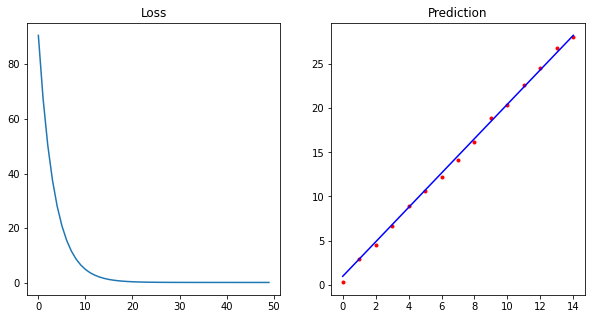

In [16]:
x = torch.FloatTensor(range(15)).unsqueeze(1) # 입력 값
y = 2*x+torch.rand(15,1) # 정답

model = LinearRegress()
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_stack = []
for epoch in range(50):
    # Pytorch는 기본설정에 옵티마이저의 gradients값들을 추후 역전파 시 가산시키도록 되어 있음,
    # 이러한 미분값 가산방식은 RNN을 학습시킬 때 편리함, 그러나 기본적인 방식의 학습일 경우
    # 학습이 한번 종료되면 반드시 옵티마이저의 이전 미분값을 zero_grad()로 초기화 하여 학습을 진행햐야 함
    optimizer.zero_grad() # 최적화는 계산을 누적시키기 때문에 매 epoch 마다 zero_grad()를 통해 값을 초기화 해준다.
    y_hat = model.forward(x)
    loss = criterion(y, y_hat)    
    loss.backward()
    optimizer.step()
    loss_stack.append(loss.item())

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")
plt.subplot(122)
plt.plot(y.numpy(), 'r.')
plt.title("Prediction")
plt.plot(y_hat.detach().numpy(), 'b-') # grad(미분값)이 포함된 Tensor를 넘파이로 변환하기전에 detach()로 grad제거
plt.show()
    

##### 5.1.2 집값 예측하기

In [80]:
# 데이터 셋 클래스
class TensorData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = y_data.shape[0]
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        return self.len

In [81]:
# 데이터 셋 만들기
df = pd.read_csv("./data/reg.csv", index_col=[0])
# 데이터 프레임을 넘파일 배열로
X = df.drop('Price', axis=1).to_numpy()
Y = df['Price'].to_numpy().reshape(-1, 1)
# 훈련 데이터와 테스트 데이터 나누기 
#  * 순서는 1)훈련X, 2)테스트X, 3)훈련Y, 4)테스트X
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [82]:
# 텐서 데이터 만들기
trainset = TensorData(X_train, Y_train)
trainLoader = DataLoader(trainset, batch_size=32, shuffle=True)
testset = TensorData(X_test, Y_test)
testLoader = DataLoader(testset, batch_size=32, shuffle=False)

In [83]:
trainset[0]

(tensor([0.0711, 0.0243, 0.6994, 0.2908, 0.6043, 0.3782, 0.9289, 0.1472, 0.1597,
         0.4133, 0.2745, 0.8814, 0.5890]),
 tensor([0.2311]))

In [84]:
# 모델 구축
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = F.relu(self.fc1(x))        
        x = self.dropout(F.relu(self.fc2(x)))        
        x = F.relu(self.fc3(x))
        return x


Epoch: 0, Loss: 0.08769230777397752
Epoch: 40, Loss: 0.016739358427003026
Epoch: 80, Loss: 0.010349675198085606
Epoch: 120, Loss: 0.008884081442374736
Epoch: 160, Loss: 0.009246913978131488
Epoch: 200, Loss: 0.008373185235541314
Epoch: 240, Loss: 0.007372043561190367
Epoch: 280, Loss: 0.007334985071793199
Epoch: 320, Loss: 0.008444131759461015
Epoch: 360, Loss: 0.007160522043704987
Epoch: 400, Loss: 0.006642199179623276
Epoch: 440, Loss: 0.006283539551077411
Epoch: 480, Loss: 0.006108397239586338


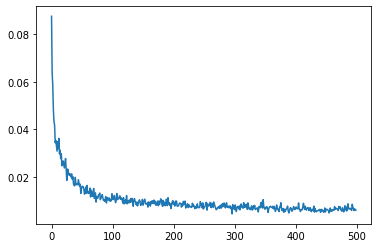

In [111]:
# 모델 학습하기
model = Regressor()
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
# weight decay는 weight들의 값이 증가하는 것을 제한함으로써, 
# 모델의 복잡도를 감소시킴으로써 제한하는 기법, 
# 즉 weight를 decay(부식시킨다라는 의미를 조금 감량시키는 의미)시켜서 
# Overfitting을 방지하는 기법
# SGD 경우 Regualarization: (1-에타^람다)W - 에타*미분(MSE)
# Regularization 수식에서 람다값이 weight_decay값임!

loss_ = []
minibatch_cnt = len(trainLoader) # 데이터로더에 포함된 미니배치의 갯수
# ex) 데이터수: 1000, 배치사이즈: 25 => minibatch_cnt: 40 => 미니배치 데이터의 개수
for i in range(500):
    running_loss = 0.0
    for data in trainLoader:
        inputs, values = data
        optimizer.zero_grad()
        y = model.forward(inputs)
        e = criterion(y, values)
        e.backward()
        optimizer.step()
        running_loss += e.item()
    epoch_loss = running_loss/minibatch_cnt
    loss_.append(epoch_loss)
    if i % 40 == 0:
        print(f"Epoch: {i}, Loss: {epoch_loss}")
        
plt.plot(loss_)
plt.show()



In [102]:
# 모델 평가하기
def evaluateModel(dataloader):
    predictions = torch.tensor([], dtype=torch.float)
    actuals = torch.tensor([], dtype=torch.float)
    with torch.no_grad(): # require_grad를 비활성화 시킴 => 역전파를 위해 사용하는 연산을 비활성화
        model.eval() # 드롭아웃과 같이 과적합 방지를 위한 정규화 기법을 비활성화 시킴
        for data in dataloader:
            inputs, values = data
            output = model.forward(inputs)
            # predictions에 output 데이터를 누적시킴
            # output 데이터가 (1, 32) 경우 axis=0으로 누적되면
            # (1, 32) -> (2, 32) 처럼 0번째 차원을 기준으로 데이터가 누적됨
            predictions = torch.cat((predictions, output), 0)
            actuals = torch.cat((actuals, values), 0)
    predictions = predictions.numpy()
    actuals = actuals.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actuals))
    return rmse



In [112]:
train_loss = evaluateModel(trainLoader)
test_loss = evaluateModel(testLoader)

print(f"Train RMSE: {train_loss}, Test RMSE: {test_loss}")

Train RMSE: 0.053189780563116074, Test RMSE: 0.10822522640228271


In [110]:
np.sqrt(1/100)

0.1